In [ ]:
!git clone https://github.com/atharva1707/Behavioral.git

Cloning into 'Behavioral'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 35 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 6.81 MiB | 5.33 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
%run /content/Behavioral/load_data.ipynb

In [ ]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

In [ ]:

def get_temporal_df(data_all, LAG, k):
  # list to store all entries
  pos_data_list = []
  neg_data_list = []
  # for all subjects
  for data in data_all:
    # iterate all rows
    for index, row in data.iterrows():
      # identify correctly recognised images being repeated for the first time
      if  row["freq"] == 2:

        # we can now define index 3 and index 2, as for the arrangement A B ...... B A
        # we have found second occurence of B which is index3
        index3 = index
        index2 = index3 - data.loc[index3,"MEMORYRECENT"] - 1

        # index3 and index2 must be one session apart
        if  data.loc[index3,"SESSION"] - data.loc[index2,"SESSION"] != LAG:
          continue
        # index2 and index3 must be 1 session apart

        # Check next k rows (excluding current row)
        for i in range(1, k+1):
          index4 = index + i
          # Reached the end of dataframe
          if index4 >= len(data):
            break

          # next 5 images must be within the same run
          if data.loc[index3,"RUN"] != data.loc[index4,"RUN"]:
            continue

          # both the images should have a previous occurence
          if data.loc[index3,"MEMORYRECENT"] == -1 or data.loc[index4,"MEMORYRECENT"] == -1:
            continue

          index1 = index4 - data.loc[index4,"MEMORYRECENT"] - 1
          # ADDING CONDITIONS FOR TEMPORAL CONTEXT MODEL

          # INDEX1 AND INDEX4 SHOULD BE FIXED_LAG SESSIONS APART
          if  data.loc[index4,"SESSION"] - data.loc[index1,"SESSION"] != LAG:
            continue
          # INDEX1 AND INDEX2 MUST BE WITHIN THE SAME SESSION FOR LOW TEMPORAL DISTANCE
          if data.loc[index1,"SESSION"] != data.loc[index2,"SESSION"]:
            continue
          # INDEX1 AND INDEX2 MUST BE WITHIN THE SAME RUN FOR LOW TEMPORAL DISTANCE
          if index1 - index2 > 60 or index2 - index1 > 60:
            continue

          # print("HERE", data.loc[index3,"MEMORYRECENT"])

          # subject, , temp_dist, temp_run,

          # LAG = index4 - index1
          # TDE = data.loc[index2,"RUN"] -  data.loc[index1,"RUN"]
          TDE = index1 - index2
          SUBJECT = data.loc[0,"SUBJECT"]
          ISCORRECT = data.loc[index4,"ISCORRECT"]
          RT = data.loc[index4, "RT"]


          data_dict = {
            'SUBJECT': SUBJECT,
            'SESSION': row["SESSION"],
            'LAG': LAG,
            'TDE': TDE,
            'ISCORRECT': ISCORRECT,
            'RT' : RT,
            'INDEX1': index1,
            'INDEX2': index2,
            'INDEX3': index3,
            'INDEX4': index4,
            'TCR': row["ISCORRECT"]
        }

          # Append the dictionary to the list
          if TDE < 0:
            data_dict['TDE'] = data_dict['TDE']
            neg_data_list.append(data_dict)
          else:
            pos_data_list.append(data_dict)

  pdf = pd.DataFrame(pos_data_list)
  ndf = pd.DataFrame(neg_data_list)
  return pdf,ndf


In [ ]:
import matplotlib.pyplot as plt

def plot_tcr_ntcr_frequency(df, start=0, end=60, bucket_size=10):
  """
  Plots the TCR and N-TCR frequency of data points for buckets of TDE.

  Args:
      df: Pandas dataframe containing columns for 'TDE' and 'TCR'.
      start: Integer specifying the starting TDE value for bucketing (inclusive).
      end: Integer specifying the ending TDE value for bucketing (exclusive).
      bucket_size: Integer specifying the size of each TDE bucket.
  """

  # Count data points in each TDE bucket for TCR and N-TCR.
  tcr_counts, tde_bins = np.histogram(df[df['TCR'] == 1]['TDE'], bins=np.arange(start, end, bucket_size))
  ntcr_counts, _ = np.histogram(df[df['TCR'] == 0]['TDE'], bins=tde_bins)

  # Calculate x-axis positions for bars with a small gap
  x_total = tde_bins[:-1] - bucket_size / 4
  x_ntcr = tde_bins[:-1] + bucket_size / 4
  x_tcr = tde_bins[:-1]

  #  plot count of tcr + ntcr on same plot
  total = tcr_counts + ntcr_counts

  # Plot the TCR and N-TCR frequencies
  plt.figure(figsize=(10, 6))
  plt.bar(x_total, total, width=bucket_size / 4, label='Total')
  plt.bar(x_tcr, tcr_counts, width=bucket_size / 4, label='TCR')
  plt.bar(x_ntcr, ntcr_counts, width=bucket_size / 4, label='N-TCR')
  plt.xlabel('TDE (Temporal Distance)')
  plt.ylabel('Frequency')  # Removed normalization for clarity
  plt.title('TCR and N-TCR Frequency by TDE Buckets')
  plt.xticks(tde_bins[:-1])  # Adjusted xticks to match bar positions
  plt.legend()
  plt.grid(True)
  plt.show()

# plot_tcr_ntcr_frequency(df[df['SUBJECT']==1], 0, 60, 10)


In [ ]:
# plot_tcr_ntcr_frequency(df[df['SUBJECT']==1], -60, 60, 10)
# plot_tcr_ntcr_frequency(df[df['SUBJECT']==2], -60, 60, 10)
# plot_tcr_ntcr_frequency(df[df['SUBJECT']==3], -60, 60, 10)
# plot_tcr_ntcr_frequency(df[df['SUBJECT']==4], -60, 60, 10)
# plot_tcr_ntcr_frequency(df[df['SUBJECT']==5], -60, 60, 10)
# plot_tcr_ntcr_frequency(df[df['SUBJECT']==6], -60, 60, 10)
# plot_tcr_ntcr_frequency(df[df['SUBJECT']==7], -60, 60, 10)
# plot_tcr_ntcr_frequency(df[df['SUBJECT']==8], -60, 60, 10)

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the data

# Step 1: Group the data by 'SESSION' and 'TCR', then calculate the mean accuracy
mean_accuracy = df.groupby(['SESSION', 'TCR'])['ISCORRECT'].mean().unstack()

# Step 2: Compute the ratio of mean accuracy for TCR=1 to TCR=0
mean_accuracy['ratio'] = mean_accuracy[1] / mean_accuracy[0]

# Step 3: Plot the ratio against SESSION
plt.figure(figsize=(10, 6))
plt.plot(mean_accuracy.index, mean_accuracy['ratio'], marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('SESSION')
plt.ylabel('Ratio of Mean Accuracy (TCR=1 / TCR=0)')
plt.title('Ratio of Mean Accuracy for TCR=1 vs TCR=0 Across Sessions')

# Show grid
plt.grid(True)

# Display the plot
plt.show()


NameError: name 'df' is not defined

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_accuracy_ratio_for_subject(df, subject, start=-60, end=60, bucket_size=10):
    """
    Plots the ratio of mean accuracy for TCR=1 and TCR=0 across sessions for a specific subject.

    Args:
        df: Pandas DataFrame containing the data.
        subject: Integer specifying the subject ID to filter the data.
        start: Integer specifying the starting TDE value for bucketing (inclusive). Default is -60.
        end: Integer specifying the ending TDE value for bucketing (exclusive). Default is 60.
        bucket_size: Integer specifying the size of each TDE bucket. Default is 10.
    """
    # Filter the data for the given subject
    subject_df = df[df['SUBJECT'] == subject]

    # Group the data by 'SESSION' and 'TCR', then calculate the mean accuracy
    mean_accuracy = subject_df.groupby(['SESSION', 'TCR'])['ISCORRECT'].mean().unstack()

    # Compute the ratio of mean accuracy for TCR=1 to TCR=0
    mean_accuracy['ratio'] = mean_accuracy[1] / mean_accuracy[0]

    # Plot the ratio against SESSION
    plt.figure(figsize=(10, 6))
    plt.plot(mean_accuracy.index, mean_accuracy['ratio'], marker='o', linestyle='-', color='b')

    # Add labels and title
    plt.xlabel('SESSION')
    plt.ylabel('Ratio of Mean Accuracy (TCR=1 / TCR=0)')
    plt.title(f'Ratio of Mean Accuracy for TCR=1 vs TCR=0 Across Sessions (Subject {subject})')

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.show()

# Example usage:
plot_accuracy_ratio_for_subject(df, 5, start=0, end=60, bucket_size=60)
plot_accuracy_ratio_for_subject(df, 6, start=0, end=60, bucket_size=60)


In [ ]:
data = load_all_data()
pdf,ndf = get_temporal_df(data,1,5)
df = pdf
df = pd.concat([df, ndf])

In [ ]:
print(df)

     SUBJECT  SESSION  LAG   TDE  ISCORRECT           RT   INDEX1   INDEX2  \
0          1      2.0    1  28.0        1.0  1167.157353    574.0    602.0   
1          1      2.0    1  59.0        1.0  1454.983036    543.0    602.0   
2          1      2.0    1  31.0        1.0  1454.983036    543.0    574.0   
3          1      2.0    1  49.0        1.0  1522.878475    529.0    578.0   
4          1      2.0    1  23.0        1.0  1184.307986    657.0    680.0   
..       ...      ...  ...   ...        ...          ...      ...      ...   
931        8     29.0    1 -16.0        0.0   903.181396  20727.0  20711.0   
932        8     30.0    1  -2.0        1.0   755.853342  21651.0  21649.0   
933        8     30.0    1 -20.0        1.0  1173.876622  21711.0  21691.0   
934        8     30.0    1 -57.0        1.0  2405.494473  21656.0  21599.0   
935        8     30.0    1 -47.0        1.0   649.154298  21662.0  21615.0   

     INDEX3  INDEX4  TCR  
0       795     799  1.0  
1       7

In [ ]:
def calculate_accuracy_LAG(all_data, lag):
  """
  This function calculates accuracy for traget images having specified lag for all participants in the provided data array.

  Args:
      all_data: A list containing 8 DataFrames. Each DataFrame represents data
                for a participant and has columns: 'memory_recent', 'session',
                and 'iscorrect'.

  Returns:
      A dictionary where keys are participant numbers (1 to 8) and values are
      their corresponding accuracy (percentage) as floats.
  """
  accuracy_dict = {}
  subject = 0
  for data in all_data:
    # iterate all rowsS
    num_total = 0
    num_correct = 0
    for index, row in data.iterrows():
      if row['MEMORYRECENT'] == -1 or row['MEMORYFIRST'] != -1:
        continue
      if row['SESSION'] == lag + data.loc[index - row['MEMORYRECENT']- 1,"SESSION"]:
        num_total  =  num_total + 1
        if row["ISCORRECT"] == 1:
          num_correct = num_correct + 1
    accuracy = num_correct / num_total
    accuracy_dict[subject+1] = accuracy
    subject = subject + 1
  return accuracy_dict

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

def run_mixed_effects_logit(df, start, end):
    """
    Fits a mixed effects logistic regression model to data for each subject.
    Filters the data based on TDE values within the specified range and TCR=1.

    Args:
        df: Pandas DataFrame containing the data.
        start: Integer specifying the minimum value of TDE for filtering.
        end: Integer specifying the maximum value of TDE for filtering.

    Returns:
        results: Dictionary with subject IDs as keys and model results as values.
    """
    results = {}

    # Group data by subject
    subject_data = {subject: subject_df for subject, subject_df in df.groupby("SUBJECT")}

    # Loop through each subject
    for subject, subject_df in subject_data.items():
        sub_df = pd.DataFrame(subject_df)

        # Filter data based on TDE range and TCR
        filtered_df = sub_df[(sub_df['TDE'] >= start) & (sub_df['TDE'] <= end)]
        # filtered_df = filtered_df[filtered_df['TCR'] == 1]

        # Build mixed effects logistic regression model
        formula = 'ISCORRECT ~ TCR'
        model = smf.mixedlm(formula, filtered_df, groups=filtered_df['SESSION'])

        # Fit the model
        result = model.fit()

        # Store model result
        results[subject] = result
        print(f"Subject {subject}:")
        print(result.summary())

    return results

# Example usage:
# results = run_mixed_effects_logit(df, start=-60, end=60)


In [ ]:
import statsmodels.formula.api as smf

def run_mixedlm_TCR(df, start, end):
    formula = 'ISCORRECT ~ TCR'
    fil_df = df[(df['TDE'] <= end) & (df['TDE'] >= start)]
    model = smf.mixedlm(formula, fil_df, groups=fil_df['SUBJECT'])
    result = model.fit()
    # print("TCR Model Summary:")
    # print(result.summary())
    return result

def run_mixedlm_TDE(df, start, end):
    formula = 'ISCORRECT ~ TDE'
    fil_df = df[(df['TDE'] <= end) & (df['TDE'] >= start)]
    fil_df = fil_df[fil_df['TCR'] == 1]
    model = smf.mixedlm(formula, fil_df, groups=fil_df['SUBJECT'])
    result = model.fit()
    # print("TDE Model Summary:")
    # print(result.summary())
    return result

def run_mixedlm_TCR_RT(df, start, end):
    formula = 'RT ~ TCR'
    fil_df = df[(df['TDE'] <= end) & (df['TDE'] >= start)]
    model = smf.mixedlm(formula, fil_df, groups=fil_df['SUBJECT'])
    result = model.fit()
    # print("TCR vs RT Model Summary:")
    # print(result.summary())
    return result

def run_mixedlm_TDE_RT(df, start, end):
    formula = 'RT ~ TDE'
    fil_df = df[(df['TDE'] <= end) & (df['TDE'] >= start)]
    model = smf.mixedlm(formula, fil_df, groups=fil_df['SUBJECT'])
    result = model.fit()
    # print("TDE vs RT Model Summary:")
    # print(result.summary())
    return result

def run_all_mixedlm_models(df, start, end):
    # print("Running TCR Model...")
    result_TCR = run_mixedlm_TCR(df, start, end)

    # print("\nRunning TDE Model...")
    result_TDE = run_mixedlm_TDE(df, start, end)

    # print("\nRunning TCR vs RT Model...")
    result_TCR_RT = run_mixedlm_TCR_RT(df, start, end)

    # print("\nRunning TDE vs RT Model...")
    result_TDE_RT = run_mixedlm_TDE_RT(df, start, end)

    return {
        "TCR_Model": result_TCR,
        "TDE_Model": result_TDE,
        "TCR_RT_Model": result_TCR_RT,
        "TDE_RT_Model": result_TDE_RT
    }




In [ ]:


%load_ext rpy2.ipython


In [ ]:
%%R
install.packages('lmerTest')

(as ‘lib’ is unspecified)


































	‘/tmp/RtmpOyaeTH/downloaded_packages’



In [ ]:
!pip install pymer4
from pymer4.models import Lmer

def run_mixedlm_TCR(df, start, end):
    # Filter the data
    fil_df = df[(df['TDE'] <= end) & (df['TDE'] >= start)]

    # Define the model formula for TCR
    formula = 'ISCORRECT ~ TCR + (1|SUBJECT)'

    # Fit the mixed model using Lmer (pymer4)
    model = Lmer(formula, data=fil_df)
    result = model.fit()

    return result

def run_mixedlm_TDE(df, start, end):
    # Filter the data
    fil_df = df[(df['TDE'] <= end) & (df['TDE'] >= start)]
    fil_df = fil_df[fil_df['TCR'] == 1]

    # Define the model formula for TDE
    formula = 'ISCORRECT ~ TDE + (1|SUBJECT)'

    # Fit the mixed model
    model = Lmer(formula, data=fil_df)
    result = model.fit()

    return result

def run_mixedlm_TCR_RT(df, start, end):
    # Filter the data
    fil_df = df[(df['TDE'] <= end) & (df['TDE'] >= start)]

    # Define the model formula for RT as the outcome
    formula = 'RT ~ TCR + (1|SUBJECT)'

    # Fit the mixed model
    model = Lmer(formula, data=fil_df)
    result = model.fit()

    return result

def run_mixedlm_TDE_RT(df, start, end):
    # Filter the data
    fil_df = df[(df['TDE'] <= end) & (df['TDE'] >= start)]

    # Define the model formula for RT as the outcome
    formula = 'RT ~ TDE + (1|SUBJECT)'

    # Fit the mixed model
    model = Lmer(formula, data=fil_df)
    result = model.fit()

    return result

def run_all_mixedlm_models(df, start, end):
    result_TCR = run_mixedlm_TCR(df, start, end)
    result_TDE = run_mixedlm_TDE(df, start, end)
    result_TCR_RT = run_mixedlm_TCR_RT(df, start, end)
    result_TDE_RT = run_mixedlm_TDE_RT(df, start, end)

    return {
        "TCR_Model": result_TCR,
        "TDE_Model": result_TDE,
        "TCR_RT_Model": result_TCR_RT,
        "TDE_RT_Model": result_TDE_RT
    }

In [ ]:
# Filter the data
start = 0
end = 20
fil_df = df[(df['TDE'] <= end) & (df['TDE'] >= start)]

from __future__ import division
import numpy as np
import pandas as pd
import statsmodels.api as sm

r = {"SUBJECT": '0 + C(SUBJECT)'}
glmm = sm.BinomialBayesMixedGLM.from_formula('ISCORRECT~TCR*TDE', r, data=fil_df)
res = glmm.fit_vb()
print(res.summary())


               Binomial Mixed GLM Results
          Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
--------------------------------------------------------
Intercept    M    -0.2323   0.1116                      
TCR          M     1.1924   0.1570                      
TDE          M     0.0078   0.0093                      
TCR:TDE      M    -0.0384   0.0133                      
SUBJECT      V    -0.5435   0.2507 0.581   0.352   0.959
Parameter types are mean structure (M) and variance
structure (V)
Variance parameters are modeled as log standard
deviations


In [ ]:
print(type(res.params))
print(res.params)


<class 'numpy.ndarray'>
[-0.23225374  1.19243433  0.00780718 -0.03844474 -0.5435377   0.185948
  0.65059574 -0.68475804 -0.24906383  0.48814185 -0.19574374 -0.51214389
  0.29975726]


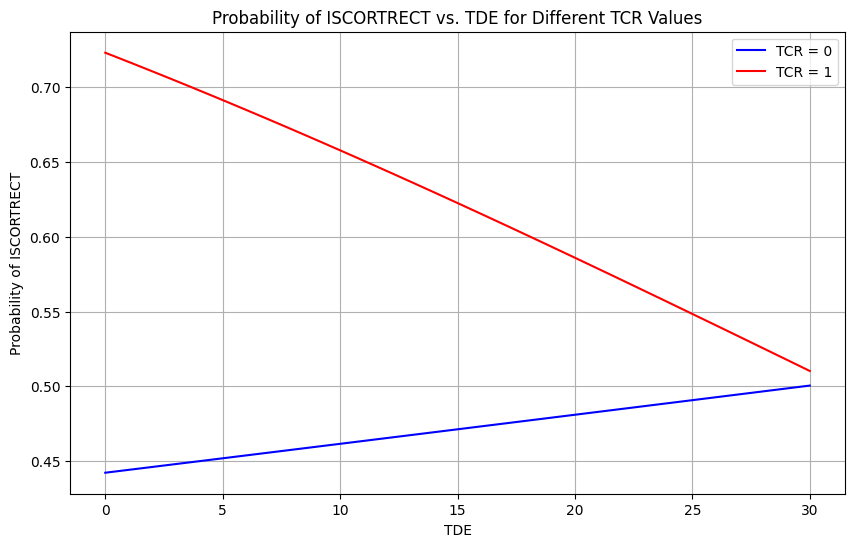

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Define parameter indices based on the output
INTERCEPT_INDEX = 0
TCR_INDEX = 1
TDE_INDEX = 2
INTERACTION_INDEX = 3

# Create a DataFrame for predictions
tde_values = np.linspace(0, 30, 100)  # 100 values from 0 to 30
data = {
    'TDE': np.tile(tde_values, 2),  # TDE values repeated for each TCR value
    'TCR': np.concatenate([np.zeros_like(tde_values), np.ones_like(tde_values)])  # 0 and 1 for TCR
}
df_plot = pd.DataFrame(data)

# Add intercept
df_plot['Intercept'] = 1

# Compute the interaction term
df_plot['TCR:TDE'] = df_plot['TCR'] * df_plot['TDE']

# Extract coefficients
intercept = res.params[INTERCEPT_INDEX]
tcr_coef = res.params[TCR_INDEX]
tde_coef = res.params[TDE_INDEX]
interaction_coef = res.params[INTERACTION_INDEX]

# Compute log-odds
log_odds = (
    intercept +
    tcr_coef * df_plot['TCR'] +
    tde_coef * df_plot['TDE'] +
    interaction_coef * df_plot['TCR:TDE']
)

# Convert log-odds to probabilities
probabilities = 1 / (1 + np.exp(-log_odds))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(tde_values, probabilities[df_plot['TCR'] == 0], label='TCR = 0', color='blue')
plt.plot(tde_values, probabilities[df_plot['TCR'] == 1], label='TCR = 1', color='red')
plt.xlabel('TDE')
plt.ylabel('Probability of ISCORTRECT')
plt.title('Probability of ISCORTRECT vs. TDE for Different TCR Values')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def run_models_for_TDE_buckets(df, start, end, bucket_size):
    results = []
    for bucket_start in range(start, end, bucket_size):
        bucket_end = min(bucket_start + bucket_size, end)
        # print(f"\nRunning models for TDE range {bucket_start}-{bucket_end}...")
        bucket_results = run_all_mixedlm_models(df, bucket_start, bucket_end)

        TCR_coeff = bucket_results["TCR_Model"].params['TCR']
        TCR_pvalue = bucket_results["TCR_Model"].pvalues['TCR']
        TDE_coeff = bucket_results["TDE_Model"].params['TDE']
        TDE_pvalue = bucket_results["TDE_Model"].pvalues['TDE']
        TCR_RT_coeff = bucket_results["TCR_RT_Model"].params['TCR']
        TCR_RT_pvalue = bucket_results["TCR_RT_Model"].pvalues['TCR']
        TDE_RT_coeff = bucket_results["TDE_RT_Model"].params['TDE']
        TDE_RT_pvalue = bucket_results["TDE_RT_Model"].pvalues['TDE']

        # Filter the DataFrame for the current TDE range
        fil_df = df[(df['TDE'] <= bucket_end) & (df['TDE'] >= bucket_start)]

        # calculate average ISCORRECT when TCR = 1
        TCR_1_df = fil_df[fil_df['TCR'] == 1]
        TCR_0_df = fil_df[fil_df['TCR'] == 0]
        TCR_1_accuracy = TCR_1_df['ISCORRECT'].mean()
        TCR_0_accuracy = TCR_0_df['ISCORRECT'].mean()

        # Get the number of observations in the current bucket
        group_size = len(fil_df)
        # print(group_size, len(df))
        data_dict = {
            'start': bucket_start,
            'end': bucket_end,
            'TCR_coeff': TCR_coeff,
            'TCR_pvalue': TCR_pvalue,
            'TDE_coeff': TDE_coeff,
            'TDE_pvalue': TDE_pvalue,
            'TCR_RT_coeff': TCR_RT_coeff,
            'TCR_RT_pvalue': TCR_RT_pvalue,
            'TDE_RT_coeff': TDE_RT_coeff,
            'TDE_RT_pvalue': TDE_RT_pvalue,
            'bucket_size': group_size,
            'TCR_1_accuracy': TCR_1_accuracy,
            'TCR_0_accuracy': TCR_0_accuracy
        }
        results.append(data_dict)
    results_df = pd.DataFrame(results)
    return results_df

def extract_coefficients_and_pvalues(result):
    # Extract the coefficients and p-values from the model result
    coef_dict = result.params.to_dict()
    pvalues_dict = result.pvalues.to_dict()

    # Combine coefficients and p-values into a single dictionary
    combined_dict = {}
    for key in coef_dict:
        combined_dict[f"{key}_coef"] = coef_dict[key]
        combined_dict[f"{key}_pvalue"] = pvalues_dict[key]

    return combined_dict

# results = run_models_for_TDE_buckets(df, 0, 60, 5)
# print(results)

In [ ]:
import pandas as pd
import warnings
# from statsmodels.base.model import ConvergenceWarning

# ignore warning just for this block
warnings.filterwarnings("ignore")

# Assuming the 'results' DataFrame is generated from your function
# pdf,ndf = get_temporal_df(data,1,10)
# df = pdf
# df = pd.concat([df, ndf])
results = run_models_for_TDE_buckets(df, -60, 60, 10)

# Function to apply color based on p-value
def highlight_pvalue(val):
    if val < 0.01:
        color = 'green'
    elif val < 0.1:
        color = 'yellow'
    else:
        color = ''
    return f'background-color: {color}'

# Function to apply a red-to-blue gradient based on TCR_coeff
def highlight_tcr_coeff(val):
    # Normalize val to be between 0 and 1 for color intensity
    norm_val = (val - results['TCR_coeff'].min()) / (results['TCR_coeff'].max() - results['TCR_coeff'].min())

    # Calculate red and blue intensity (red decreases, blue increases)
    red_intensity = int((1 - norm_val) * 255)
    blue_intensity = int(norm_val * 255)

    # Return the color as a combination of red and blue components
    color = f'background-color: rgb({red_intensity}, 0, {blue_intensity})'
    return color

# Apply the highlight function to the p-value columns
styled_results = results.style.applymap(highlight_pvalue, subset=pd.IndexSlice[:, ['TCR_pvalue', 'TDE_pvalue']])

# Apply the TCR coefficient red-to-blue gradient coloring
styled_results = styled_results.applymap(highlight_tcr_coeff, subset=['TCR_coeff'])

# Display the styled DataFrame
styled_results

# warning on


,start,end,TCR_coeff,TCR_pvalue,TDE_coeff,TDE_pvalue,TCR_RT_coeff,TCR_RT_pvalue,TDE_RT_coeff,TDE_RT_pvalue,bucket_size,TCR_1_accuracy,TCR_0_accuracy
0,-60,-50,0.219947,0.000293,0.006557,0.620501,99.550492,0.149942,1.505878,0.897114,278,0.718121,0.434109
1,-50,-40,0.077184,0.113718,0.006009,0.589599,-48.300317,0.408889,-1.927258,0.846486,384,0.658654,0.488636
2,-40,-30,0.116451,0.015222,0.000268,0.979176,-66.682229,0.267578,14.272092,0.127855,384,0.661376,0.476923
3,-30,-20,0.216638,0.000303,-0.006380,0.600009,-29.219947,0.664254,1.658355,0.873063,274,0.731884,0.466667
4,-20,-10,0.032707,0.534748,0.007007,0.497701,33.871235,0.576429,3.317696,0.703286,356,0.659091,0.469274
5,-10,0,0.183191,0.000310,0.006500,0.572273,-70.096941,0.221580,5.091948,0.622930,408,0.694064,0.460317
6,0,10,0.152163,0.002460,-0.021660,0.065783,16.727273,0.776200,-15.490230,0.149381,386,0.657005,0.404494
7,10,20,0.158906,0.006077,-0.017341,0.225564,102.421563,0.112624,11.626320,0.312946,324,0.668571,0.436242
8,20,30,0.087486,0.130977,-0.003538,0.770852,102.468097,0.125824,-4.289398,0.671575,350,0.649123,0.480447
9,30,40,0.191137,0.000696,0.003893,0.688489,-33.423947,0.589413,3.344605,0.713377,312,0.715084,0.428571


In [ ]:
start =  10
end = 15
formula = 'ISCORRECT ~ TDE'
fil_df = df[(df['TDE'] <= end) & (df['TDE'] >= start)]
fil_df = fil_df[fil_df['TCR'] == 1]
model = smf.mixedlm(formula, fil_df, groups=fil_df['SUBJECT'], re_formula="~TDE")
result = model.fit()
# print("TDE Model Summary:")
print(result.summary())
# return result

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  ISCORRECT
No. Observations:  39       Method:              REML     
No. Groups:        8        Scale:               0.1852   
Min. group size:   3        Log-Likelihood:      -26.6467 
Max. group size:   7        Converged:           Yes      
Mean group size:   4.9                                    
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.817    0.396  2.065 0.039  0.042  1.592
TDE             -0.006    0.032 -0.192 0.848 -0.069  0.057
Group Var        0.033                                    
Group x TDE Cov -0.001                                    
TDE Var          0.000                                    



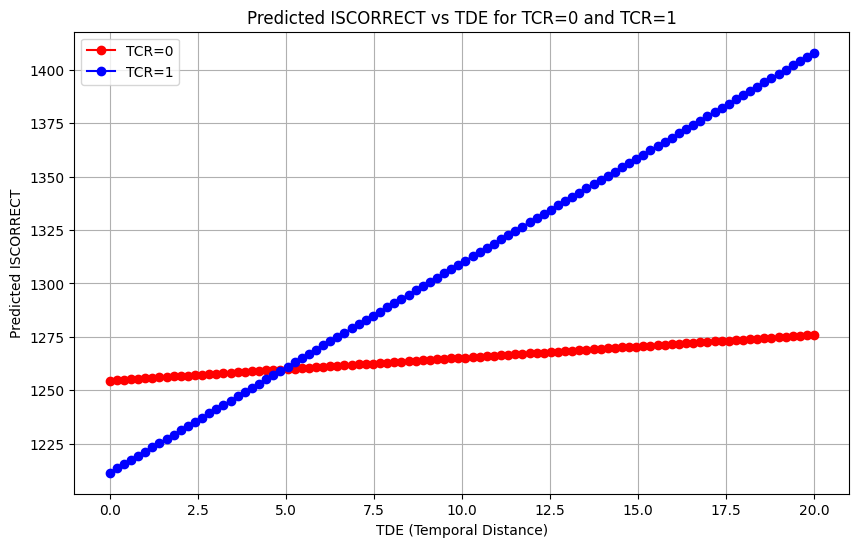

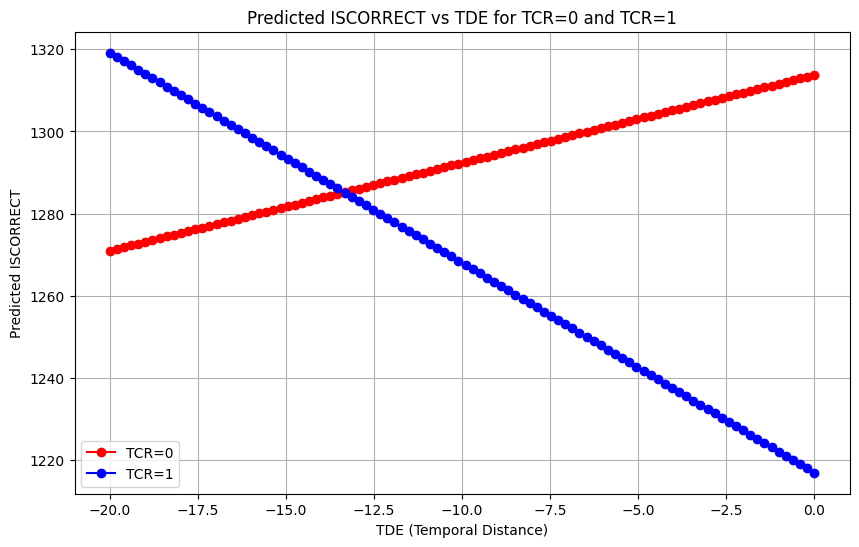

In [ ]:
import statsmodels.formula.api as smf
import warnings

def run_mixedlm_interactive(df, start, end):
    """
    Runs a mixed effects logistic regression model to estimate the effect of TDE
    for both TCR=0 and TCR=1, including subject-level random effects.

    Args:
        df: Pandas DataFrame containing the data.
        start: Integer specifying the minimum value of TDE for filtering.
        end: Integer specifying the maximum value of TDE for filtering.

    Returns:
        result: The fitted mixed effects model.
    """
    # Suppress convergence warnings for cleaner output
    warnings.filterwarnings('ignore', category=Warning)

    # Filter data based on TDE range
    fil_df = df[(df['TDE'] <= end) & (df['TDE'] >= start)]

    # Formula includes interaction between TDE and TCR, with random intercept for SUBJECT
    formula = 'RT ~ TDE * TCR'

    # Build and fit the mixed effects logistic regression model
    model = smf.mixedlm(formula, fil_df, groups=fil_df['SUBJECT'], re_formula="~TDE")
    result = model.fit()

    return result

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'result' is your fitted model from the mixed effects regression
# and 'df' is your original dataset

def plot_predicted_iscorrect_vs_tde(model, df, start, end):
    # Create a range of TDE values for the x-axis
    tde_range = np.linspace(start, end, 100)

    # DataFrame to hold TDE values and TCR (for both 0 and 1)
    plot_data = pd.DataFrame({
        'TDE': np.tile(tde_range, 2),
        'TCR': np.repeat([0, 1], len(tde_range))
    })

    # Predict the ISCORRECT values using the fitted model
    plot_data['Predicted_ISCORRECT'] = model.predict(plot_data)

    # Split the data by TCR value (two lines: one for TCR=0 and one for TCR=1)
    tcr_0_data = plot_data[plot_data['TCR'] == 0]
    tcr_1_data = plot_data[plot_data['TCR'] == 1]

    # Plot the predicted ISCORRECT values
    plt.figure(figsize=(10, 6))
    plt.plot(tcr_0_data['TDE'], tcr_0_data['Predicted_ISCORRECT'], label='TCR=0', color='r', linestyle='-', marker='o')
    plt.plot(tcr_1_data['TDE'], tcr_1_data['Predicted_ISCORRECT'], label='TCR=1', color='b', linestyle='-', marker='o')

    # Add labels and title
    plt.xlabel('TDE (Temporal Distance)')
    plt.ylabel('Predicted ISCORRECT')
    plt.title('Predicted ISCORRECT vs TDE for TCR=0 and TCR=1')
    plt.legend()

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.show()

# Use the combined model with interaction
result = run_mixedlm_interactive(df, start=0, end=20)

# Plot the predicted ISCORRECT vs TDE
plot_predicted_iscorrect_vs_tde(result, df, start=0, end=20)

# Use the combined model with interaction
result = run_mixedlm_interactive(df, start=-20, end=0)

# Plot the predicted ISCORRECT vs TDE
plot_predicted_iscorrect_vs_tde(result, df, start=-20, end=0)




              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   RT         
No. Observations:     710       Method:               REML       
No. Groups:           8         Scale:                288953.4948
Min. group size:      83        Log-Likelihood:       -5463.7728 
Max. group size:      94        Converged:            No         
Mean group size:      88.8                                       
-----------------------------------------------------------------
                  Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1254.574   70.856 17.706 0.000 1115.699 1393.449
TDE                 1.065    5.740  0.186 0.853  -10.184   12.314
TCR               -43.115   84.787 -0.509 0.611 -209.295  123.064
TDE:TCR             8.760    7.479  1.171 0.241   -5.898   23.418
Group Var       11509.936   20.040                               
Group x TDE Cov   561.07

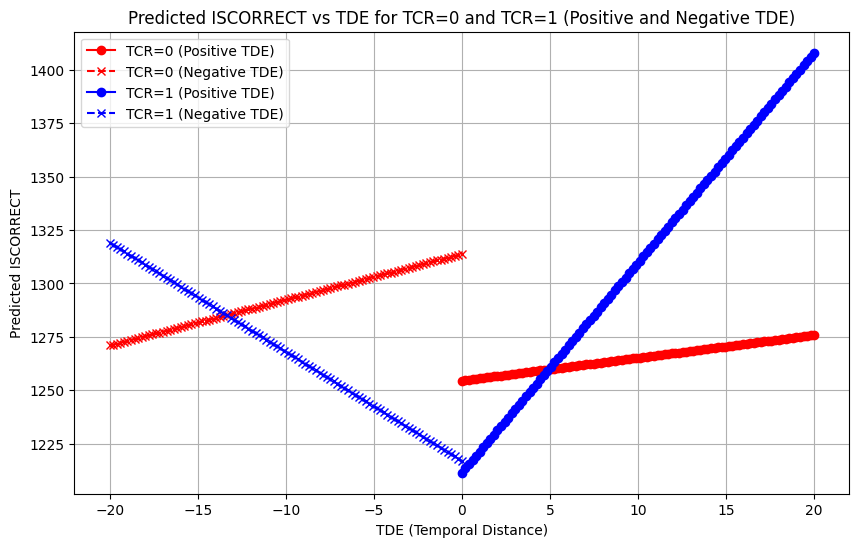

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_combined_predicted_iscorrect_vs_tde(model_positive, model_negative, start_pos, end_pos, start_neg, end_neg):
    """
    Plots predicted ISCORRECT for both positive and negative TDE values, with TCR=0 and TCR=1.

    Args:
        model_positive: The fitted mixed effects model for positive TDE values.
        model_negative: The fitted mixed effects model for negative TDE values.
        start_pos: The minimum positive TDE value.
        end_pos: The maximum positive TDE value.
        start_neg: The minimum negative TDE value.
        end_neg: The maximum negative TDE value.
    """

    # Create TDE ranges for positive and negative values
    tde_range_pos = np.linspace(start_pos, end_pos, 100)
    tde_range_neg = np.linspace(start_neg, end_neg, 100)

    # DataFrame to hold TDE values and TCR (for both 0 and 1)
    plot_data_pos = pd.DataFrame({
        'TDE': np.tile(tde_range_pos, 2),
        'TCR': np.repeat([0, 1], len(tde_range_pos))
    })

    plot_data_neg = pd.DataFrame({
        'TDE': np.tile(tde_range_neg, 2),
        'TCR': np.repeat([0, 1], len(tde_range_neg))
    })

    # Predict ISCORRECT values using the positive and negative models
    plot_data_pos['Predicted_ISCORRECT'] = model_positive.predict(plot_data_pos)
    plot_data_neg['Predicted_ISCORRECT'] = model_negative.predict(plot_data_neg)

    # Split the data by TCR value (two lines: one for TCR=0 and one for TCR=1)
    tcr_0_data_pos = plot_data_pos[plot_data_pos['TCR'] == 0]
    tcr_1_data_pos = plot_data_pos[plot_data_pos['TCR'] == 1]

    tcr_0_data_neg = plot_data_neg[plot_data_neg['TCR'] == 0]
    tcr_1_data_neg = plot_data_neg[plot_data_neg['TCR'] == 1]

    # Plot the predicted ISCORRECT values for both positive and negative TDE
    plt.figure(figsize=(10, 6))

    # Plot for TCR = 0
    plt.plot(tcr_0_data_pos['TDE'], tcr_0_data_pos['Predicted_ISCORRECT'], label='TCR=0 (Positive TDE)', color='r', linestyle='-', marker='o')
    plt.plot(tcr_0_data_neg['TDE'], tcr_0_data_neg['Predicted_ISCORRECT'], label='TCR=0 (Negative TDE)', color='r', linestyle='--', marker='x')

    # Plot for TCR = 1
    plt.plot(tcr_1_data_pos['TDE'], tcr_1_data_pos['Predicted_ISCORRECT'], label='TCR=1 (Positive TDE)', color='b', linestyle='-', marker='o')
    plt.plot(tcr_1_data_neg['TDE'], tcr_1_data_neg['Predicted_ISCORRECT'], label='TCR=1 (Negative TDE)', color='b', linestyle='--', marker='x')

    # Add labels and title
    plt.xlabel('TDE (Temporal Distance)')
    plt.ylabel('Predicted ISCORRECT')
    plt.title('Predicted ISCORRECT vs TDE for TCR=0 and TCR=1 (Positive and Negative TDE)')
    plt.legend()

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.show()

# Run the models for positive and negative TDE ranges
model_positive = run_mixedlm_interactive(df, start=0, end=20)
model_negative = run_mixedlm_interactive(df, start=-20, end=0)
print(model_positive.summary())
print(model_negative.summary())

# Plot both models together
plot_combined_predicted_iscorrect_vs_tde(model_positive, model_negative, start_pos=0, end_pos=20, start_neg=-20, end_neg=0)


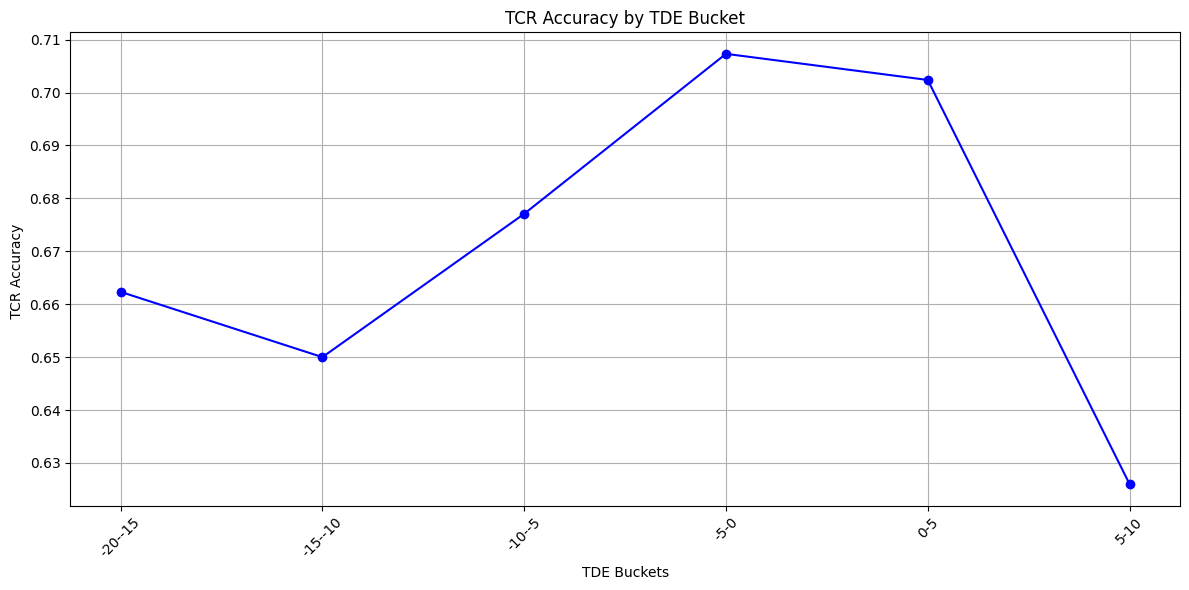

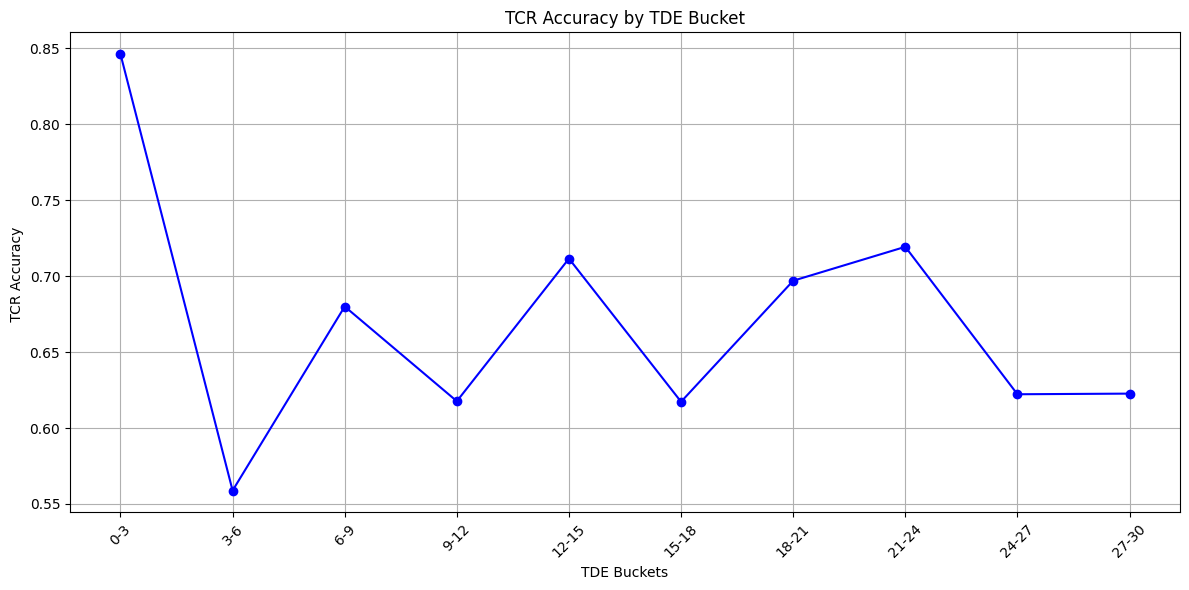

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_accuracy_ratios(df, start, end, bucket_size):
    # Initialize lists to store the ratios for each bucket
    bucket_means = []

    # Create buckets
    buckets = [(i, i + bucket_size) for i in range(start, end, bucket_size)]

    for bucket_start, bucket_end in buckets:
        # Filter rows within the bucket range
        bucket_df = df[(df['TDE'] >= bucket_start) & (df['TDE'] < bucket_end)]

        # Calculate means for TCR == 1 and TCR == 0
        mean_tcr = bucket_df[bucket_df['TCR'] == 1]['ISCORRECT'].mean()
        mean_ntcr = bucket_df[bucket_df['TCR'] == 0]['ISCORRECT'].mean()

        # Compute ratio
        if mean_ntcr != 0:
            ratio = mean_tcr /1
        else:
            ratio = float('inf')  # Handle division by zero

        bucket_means.append(ratio)

    # Plot results
    plt.figure(figsize=(12, 6))

    bucket_labels = [f'{start}-{start + bucket_size}' for start, end in buckets]

    plt.plot(bucket_labels, bucket_means, marker='o', linestyle='-', color='b')

    plt.xlabel('TDE Buckets')
    plt.ylabel(' TCR Accuracy  ')
    plt.title('TCR Accuracy by TDE Bucket')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming df is your DataFrame with 'TDE', 'TCR', and 'ISCORRECT' columns
# df = pd.DataFrame({
#     'TDE': [...],  # TDE values
#     'TCR': [...],  # TCR indicator (1 or 0)
#     'ISCORRECT': [...]  # Accuracy values
# })

# Call the function with your DataFrame and desired parameters
plot_accuracy_ratios(df, start=-20, end=10, bucket_size=5)
plot_accuracy_ratios(df, start=0, end=30, bucket_size=3)


In [ ]:
def count_filtered_rows(df, TCR_VALUE, TDE_START, TDE_END, SUBJECT=1, ALL_SUBJECT=False ):
    """
    Count rows in DataFrame `df` based on specified conditions.

    Parameters:
    - df (pandas.DataFrame): Input DataFrame containing 'TCR', 'TDE', and 'ISCORRECT' columns.
    - TCR_VALUE (int or float): Value of 'TCR' to filter rows.
    - TDE_START (int or float): Start value (inclusive) of 'TDE' range to filter rows.
    - TDE_END (int or float): End value (exclusive) of 'TDE' range to filter rows.

    Returns:
    - int: Number of rows in `df` satisfying the specified conditions.
    """
    # Filter rows based on conditions
    if ALL_SUBJECT:
        filtered_df = df[(df['TCR'] == TCR_VALUE) &
                         (df['TDE'] >= TDE_START) &
                         (df['TDE'] < TDE_END)]
    else:
        filtered_df = df[(df['TCR'] == TCR_VALUE) &
                         (df['TDE'] >= TDE_START) &
                         (df['TDE'] < TDE_END) &
                         (df['SUBJECT'] == SUBJECT)]

    # Count the number of rows in the filtered DataFrame
    if len(filtered_df) == 0:
      if ALL_SUBJECT:
        accuracy, reaction_time,  _ = count_filtered_rows(df,TCR_VALUE, TDE_START=-60, TDE_END=60,  ALL_SUBJECT=True)
      else:
        accuracy, reaction_time,  _ = count_filtered_rows(df,TCR_VALUE, TDE_START, TDE_END, SUBJECT, ALL_SUBJECT=True)
      accuracy = 1
    else:
      accuracy = len(filtered_df[filtered_df["ISCORRECT"] == 1]) / len(filtered_df)
      reaction_time = filtered_df["RT"].mean()

    count = len(filtered_df)

    return accuracy, reaction_time, count

In [ ]:
# ACCURACY COMPARISION
# print(df)

print(count_filtered_rows(df,1,0,3, ALL_SUBJECT=True))
print(count_filtered_rows(df=df, TCR_VALUE=1, TDE_START=0, TDE_END=3, ALL_SUBJECT=True))
print(count_filtered_rows(df=df, TCR_VALUE=1, TDE_START=3, TDE_END=6, ALL_SUBJECT=True))
print(count_filtered_rows(df=df, TCR_VALUE=1, TDE_START=6, TDE_END=9, ALL_SUBJECT=True))
print(count_filtered_rows(df=df, TCR_VALUE=1, TDE_START=9, TDE_END=12, ALL_SUBJECT=True))
print(count_filtered_rows(df=df, TCR_VALUE=1, TDE_START=12, TDE_END=15, ALL_SUBJECT=True))
print(count_filtered_rows(df=df, TCR_VALUE=1, TDE_START=15, TDE_END=18, ALL_SUBJECT=True))
print(count_filtered_rows(df=df, TCR_VALUE=1, TDE_START=18, TDE_END=21, ALL_SUBJECT=True))
print(count_filtered_rows(df=df, TCR_VALUE=1, TDE_START=21, TDE_END=24, ALL_SUBJECT=True))
print(count_filtered_rows(df=df, TCR_VALUE=1, TDE_START=24, TDE_END=27, ALL_SUBJECT=True))
print("_________________")
print(count_filtered_rows(df=df, TCR_VALUE=0, TDE_START=0, TDE_END=3, ALL_SUBJECT=True))
print(count_filtered_rows(df=df, TCR_VALUE=0, TDE_START=3, TDE_END=6, ALL_SUBJECT=True))
print(count_filtered_rows(df=df, TCR_VALUE=0, TDE_START=6, TDE_END=9, ALL_SUBJECT=True))
print(count_filtered_rows(df=df, TCR_VALUE=0, TDE_START=9, TDE_END=12, ALL_SUBJECT=True))
print(count_filtered_rows(df=df, TCR_VALUE=0, TDE_START=12, TDE_END=15, ALL_SUBJECT=True))
print(count_filtered_rows(df=df, TCR_VALUE=0, TDE_START=15, TDE_END=18, ALL_SUBJECT=True))
print(count_filtered_rows(df=df, TCR_VALUE=0, TDE_START=18, TDE_END=21, ALL_SUBJECT=True))
print(count_filtered_rows(df=df, TCR_VALUE=0, TDE_START=21, TDE_END=24, ALL_SUBJECT=True))
print(count_filtered_rows(df=df, TCR_VALUE=0, TDE_START=24, TDE_END=27, ALL_SUBJECT=True))


(0.625, 1422.471542001972, 8)
(0.625, 1422.471542001972, 8)
(0.8222222222222222, 1274.6865765985906, 45)
(0.7708333333333334, 1068.6913261065172, 48)
(0.7692307692307693, 1302.1602767679933, 26)
(0.48148148148148145, 1594.6423285541405, 27)
(0.8, 1051.8007570716159, 15)
(0.3684210526315789, 1435.0773833722615, 19)
(0.8620689655172413, 1383.786249864827, 29)
(0.7142857142857143, 1343.0640775735096, 28)
_________________
(0.6666666666666666, 1326.854882000892, 6)
(0.5185185185185185, 1256.5102217788028, 27)
(0.5652173913043478, 1251.022738175621, 46)
(0.4090909090909091, 1316.1001449574005, 22)
(0.4594594594594595, 1296.3418619186432, 37)
(0.6470588235294118, 1173.7830859404257, 17)
(0.3333333333333333, 1425.367554854347, 21)
(0.5142857142857142, 1359.060956797683, 35)
(0.4583333333333333, 1259.8194677819567, 24)


In [ ]:
import matplotlib.pyplot as plt

average_subject_wise = calculate_accuracy_LAG(data,1)

def get_subject_wise_accuracy(data, TLdf):
  """
  Calculates and returns TCR and NTCR accuracy for all subjects in a dictionary.

  Args:
      data: A dictionary containing average accuracy for each subject.
      TLdf: The DataFrame containing all trial data.

  Returns:
      A dictionary with subject IDs as keys and another dictionary as values.
      The inner dictionary has keys 'average_accuracy', 'tcr_accuracy', and 'ntcr_accuracy'.
  """

  subject_wise_accuracy = {}
  for subject in TLdf['SUBJECT'].unique():
    # Get average accuracy for the subject

    # Filter TLdf for the subject
    subject_data = TLdf[TLdf['SUBJECT'] == subject]

    # Calculate TCR and NTCR accuracy
    tcr_correct = len(subject_data[(subject_data['ISCORRECT'] * subject_data['TCR']) == 1])
    tcr_total = len(subject_data[subject_data['TCR'] == True])
    tcr_accuracy = tcr_correct / tcr_total if tcr_total > 0 else 0

    ntcr_correct = len(subject_data[(subject_data['ISCORRECT'] * (1-subject_data['TCR'])) == True])
    ntcr_total = len(subject_data[subject_data['TCR'] == False])
    ntcr_accuracy = ntcr_correct / ntcr_total if ntcr_total > 0 else 0

    # Store subject-wise accuracy data
    subject_wise_accuracy[subject] = {
        'tcr_accuracy': tcr_accuracy,
        'ntcr_accuracy': ntcr_accuracy
    }

    for subject, accuracy in average_subject_wise.items():
      if subject in subject_wise_accuracy:
        subject_wise_accuracy[subject]['average_accuracy'] = accuracy

  return subject_wise_accuracy


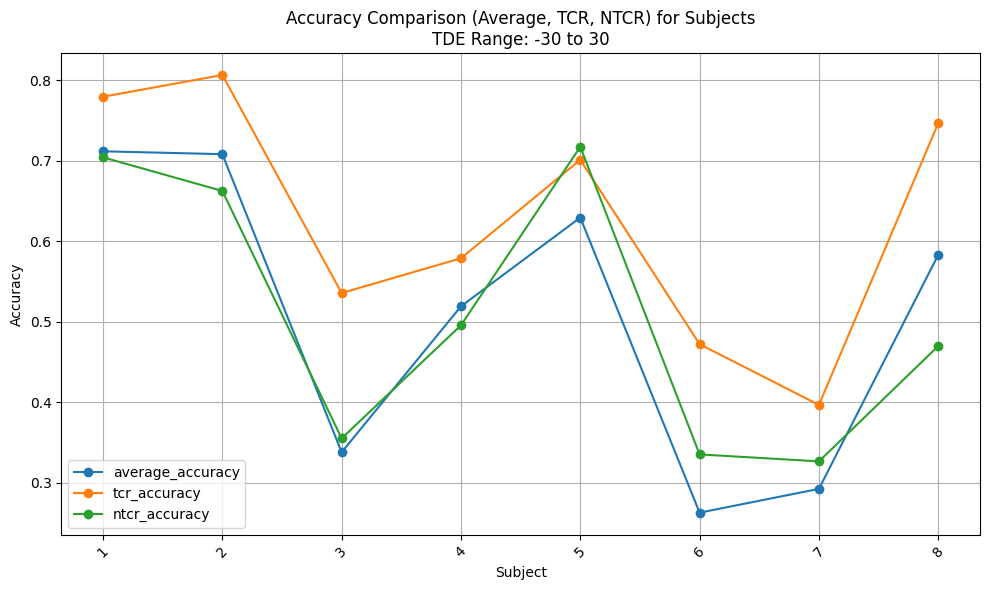

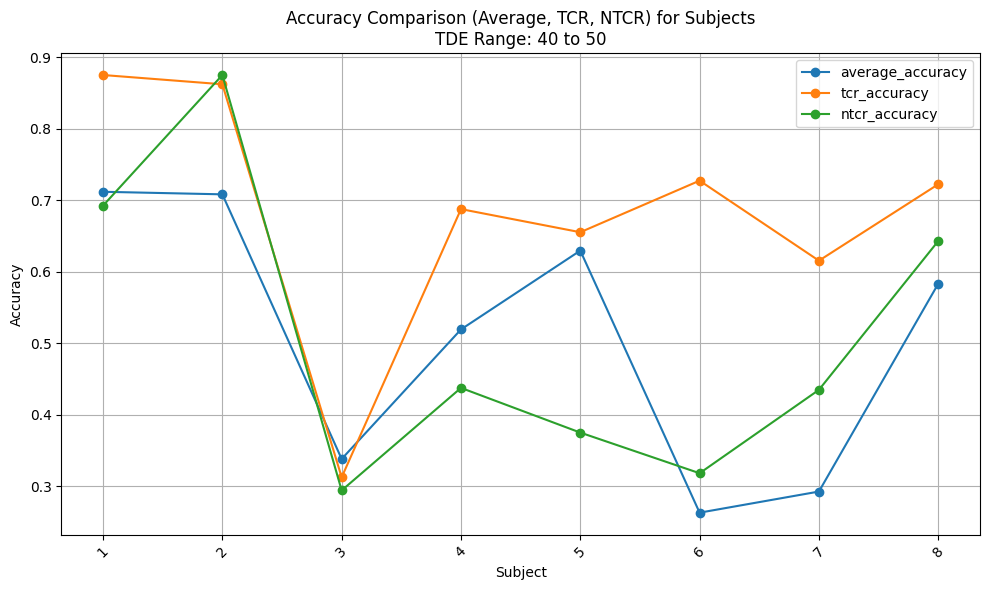

In [ ]:
import matplotlib.pyplot as plt

def plot_subject_accuracies(data, df, TDE_start, TDE_end):
    """
    Plots accuracy comparisons (average_accuracy, tcr_accuracy, ntcr_accuracy) for each subject
    within the specified TDE range.

    Parameters:
    - data: Data used for calculating subject-wise accuracy
    - df: DataFrame containing the data
    - TDE_start: Start of the TDE range
    - TDE_end: End of the TDE range
    """
    # get filtered_df
    filtered_df = df[(df['TDE'] >= TDE_start) & (df['TDE'] < TDE_end)]
    # Create a dictionary to store subject-wise accuracy data
    subject_wise_accuracy = get_subject_wise_accuracy(data, filtered_df)


    subjects = []
    accuracy_types = ['average_accuracy', 'tcr_accuracy', 'ntcr_accuracy']
    accuracies = {accuracy_type: [] for accuracy_type in accuracy_types}

    # print(subject_wise_accuracy)
    # Extract data for plotting
    for subject, d in subject_wise_accuracy.items():
        # print(subject,d)
        subjects.append(subject)
        for accuracy_type in accuracy_types:
            if accuracy_type in d:
                accuracies[accuracy_type].append(d[accuracy_type])
            else:
                accuracies[accuracy_type].append(None)  # Handle missing data
    # print(accuracies)

    # Create the line chart
    plt.figure(figsize=(10, 6))
    for accuracy_type, accuracy in accuracies.items():
        plt.plot(subjects, accuracy, label=accuracy_type, marker='o', linestyle='-')

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.xlabel('Subject')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Comparison (Average, TCR, NTCR) for Subjects\n'
              f'TDE Range: {TDE_start} to {TDE_end}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()


# Example usage:
# Assuming `data` and `df` are your data and DataFrame respectively, and TDE_start and TDE_end are defined
# TDE_start = -6
# TDE_end = 6
# plot_subject_accuracies(data, df, TDE_start, TDE_end)

# plot_subject_accuracies(data, df, 0, 20)
# plot_subject_accuracies(data, df, 0, 40)
# plot_subject_accuracies(data, df, 0, 60)
plot_subject_accuracies(data, df, -30, 30)
plot_subject_accuracies(data, df, 40, 50)
plt.show()
# plot_subject_accuracies(data, df, 20, 40)


In [ ]:
print(df)

In [ ]:
# Extract data for plotting
subjects = []
accuracy_types = ['average_accuracy', 'tcr_accuracy', 'ntcr_accuracy']
accuracies = {}  # Dictionary to store accuracy data by type

for subject, d in subject_wise_data.items():
  subjects.append(subject)
  for accuracy_type in accuracy_types:
    if accuracy_type not in accuracies:
      accuracies[accuracy_type] = []
    accuracies[accuracy_type].append(d[accuracy_type])

# Create the line chart
plt.figure(figsize=(10, 6))
for accuracy_type, accuracy in accuracies.items():
  plt.plot(subjects, accuracy, label=accuracy_type, marker='o', linestyle='-')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Average, TCR, NTCR) for TDE ')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
# ACCURACY COMPARISION
print(count_filtered_rows(df,1,0,3))
print(count_filtered_rows(df,1,3,6))
print(count_filtered_rows(df,1,6,9))
print(count_filtered_rows(df,1,9,12))
print(count_filtered_rows(df,1,12,15))
print(count_filtered_rows(df,1,15,18))
print(count_filtered_rows(df,1,18,21))
print(count_filtered_rows(df,1,21,24))
print(count_filtered_rows(df,1,24,27))
print("_________________")
print(count_filtered_rows(df,0,0,3))
print(count_filtered_rows(df,0,3,6))
print(count_filtered_rows(df,0,6,9))
print(count_filtered_rows(df,0,9,12))
print(count_filtered_rows(df,0,12,15))
print(count_filtered_rows(df,0,15,18))
print(count_filtered_rows(df,0,18,21))
print(count_filtered_rows(df,0,21,24))
print(count_filtered_rows(df,0,24,27))


In [ ]:
def calculate_accuracy_per_bucket_subject(df, start, end, bucket_size, subject):
  """
  Calculates and stores accuracy counts for different TCR values and buckets.

  Args:
      df: Pandas DataFrame containing the data.
      start: Starting value for the bucket range (inclusive).
      end: Ending value for the bucket range (exclusive).
      bucket_size: Size of each bucket.

  Returns:
      A tuple containing two arrays:
          - tcr_1_counts: Array of accuracy counts for TCR=1 in each bucket.
          - tcr_0_counts: Array of accuracy counts for TCR=0 in each bucket.
  """

  # Calculate the number of buckets based on start, end, and size
  num_buckets = int((end - start) // bucket_size)
  tcr_0_counts = [0]*num_buckets
  # Create bucket ranges dynamically
  bucket_ranges = []
  for i in range(num_buckets):
    lower_bound = start + i * bucket_size
    upper_bound = min(end, lower_bound + bucket_size)  # Ensure upper bound doesn't exceed end
    bucket_ranges.append((lower_bound, upper_bound))

  # Rest of the code remains the same as before...

  # Loop through TCR values (1 and 0)
  for tcr_value in [1, 0]:
  # for tcr_value in [1, 0]:
    # Subset data for specific TCR value

    # Loop through bucket ranges and count occurrences
    bucket_counts = []
    bucket_accuracy = []
    for lower_bound, upper_bound in bucket_ranges:
      accuracy, _ , count = count_filtered_rows(df,tcr_value, lower_bound, upper_bound, subject)
      bucket_counts.append(count)
      bucket_accuracy.append(accuracy)

    # Store counts for this TCR value
    if tcr_value == 1:
      tcr_1_counts = bucket_counts
      tcr_1_accuracy = bucket_accuracy
    else:
      tcr_0_counts = bucket_counts
      tcr_0_accuracy = bucket_accuracy

  return bucket_ranges, tcr_1_accuracy, tcr_0_accuracy, tcr_1_counts, tcr_0_counts




In [ ]:
import matplotlib.pyplot as plt

def plot_graph(tcr_1_counts, tcr_0_counts, bucket_ranges, start_label="Start", end_label="End"):
  """
  Plots accuracy vs. TDE range for TCR=1 and TCR=0.

  Args:
      tcr_1_counts: Array of accuracy counts for TCR=1 in each bucket.
      tcr_0_counts: Array of accuracy counts for TCR=0 in each bucket.
      bucket_ranges: List of tuples representing bucket ranges (lower, upper).
      start_label: Label for the starting value on the x-axis (default: "Start").
      end_label: Label for the ending value on the x-axis (default: "End").
  """

  # Extract bucket centers for x-axis labels
  bucket_centers = [(lower + upper) / 2 for lower, upper in bucket_ranges]

  # Create the plot
  plt.figure(figsize=(10, 6))

  # Plot TCR=1 accuracy (blue line)
  plt.plot(bucket_centers, tcr_1_counts, 'o-', label='TCR=1', color='b')

  # Plot TCR=0 accuracy (red line)
  plt.plot(bucket_centers, tcr_0_counts, 'o-', label='TCR=0', color='r')

  # Set labels and title
  plt.xlabel(f"{start_label} - {end_label} of TDE Range")
  plt.ylabel('Accuracy Count')
  plt.title('Accuracy Distribution by TDE Range (Bucket Centers)')
  plt.legend()

  # Rotate x-axis labels for readability if needed
  plt.xticks(rotation=45)

  # Display the plot
  plt.grid(True)
  plt.tight_layout()
  plt.show()


def plot_accuracy_per_bucket_subject(df, start, end, bucket_size, subject):
  bucket_ranges, tcr_1_counts, tcr_0_counts = calculate_accuracy_per_bucket_subject(df, start, end, bucket_size, subject)
# Call the plotting function with the calculated counts and bucket ranges
  plot_graph(tcr_1_counts, tcr_0_counts, bucket_ranges)


[1.0, 0.7142857142857143, 0.5833333333333334, 0.8571428571428571, 0.8333333333333334, 0.7272727272727273, 1.0, 0.9285714285714286, 0.5]
[0.6666666666666666, 0.6363636363636364, 0.6, 1.0, 1.0, 0.7777777777777778, 0.8571428571428571, 0.8, 0.75]
[0.6666666666666666, 1.0, 0.16666666666666666, 0.75, 0.5, 0.6, 1.0, 0.5, 0.8]
[0.6, 0.4, 0.6, 0.6, 0.6666666666666666, 0.5, 0.75, 0.5, 0.4]
[0.75, 0.7142857142857143, 0.7272727272727273, 1.0, 0.5, 1.0, 0.5, 0.8461538461538461, 0.625]
[1, 0.6666666666666666, 1.0, 0.25, 0.25, 0.4444444444444444, 1.0, 0.6666666666666666, 0.25]
[0.0, 0.0, 0.5, 0.6666666666666666, 0.25, 0.6666666666666666, 0.5, 0.5714285714285714, 0.0]
[0.3333333333333333, 0.375, 0.7777777777777778, 0.6666666666666666, 0.8, 0.9, 0.75, 0.7777777777777778, 0.8571428571428571]


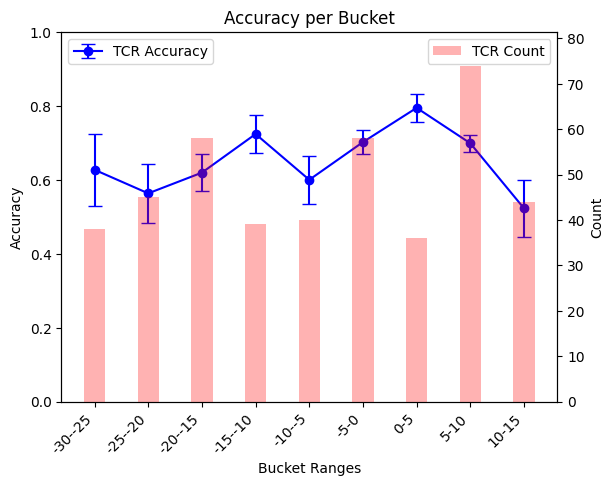

In [ ]:

def get_bucket_accuracy(df, start, end, bucket_size):
    num_buckets = int((end - start) // bucket_size)

    # Create TDE bucket ranges dynamically
    bucket_ranges = []
    for i in range(num_buckets):
        lower_bound = start + i * bucket_size
        upper_bound = min(end, lower_bound + bucket_size)  # Ensure upper bound doesn't exceed end
        bucket_ranges.append((lower_bound, upper_bound))

    tcr_accuracy = [0] * num_buckets
    tcr_count = [0]* num_buckets
    ntcr_accuracy = [0] * num_buckets
    mse_error = [0] * num_buckets

    for i in range(1, 9):
        _, tcr_accuracy_sub, ntcr_accuracy_sub, tcr_count_sub, _ = calculate_accuracy_per_bucket_subject(df, start, end, bucket_size, i)
        print(tcr_accuracy_sub)
        # Add values of tcr_accuracy_sub to corresponding values of tcr_accuracy
        for j in range(num_buckets):
            tcr_accuracy[j] += tcr_accuracy_sub[j]
            tcr_count[j] += tcr_count_sub[j]
            ntcr_accuracy[j] += ntcr_accuracy_sub[j]


    # Divide final values by 8
    tcr_accuracy = [value / 8 for value in tcr_accuracy]
    ntcr_accuracy = [value / 8 for value in ntcr_accuracy]

    for i in range(1, 9):
        _, tcr_accuracy_sub, ntcr_accuracy_sub,  tcr_count_sub, _ = calculate_accuracy_per_bucket_subject(df, start, end, bucket_size, i)
        # Add values of tcr_accuracy_sub to corresponding values of tcr_accuracy
        for j in range(num_buckets):
            mse_error[j] += (tcr_accuracy_sub[j] - tcr_accuracy[j])*(tcr_accuracy_sub[j] - tcr_accuracy[j])

    mse_error = [value / 8 for value in mse_error]

    return bucket_ranges, tcr_accuracy, ntcr_accuracy, mse_error, tcr_count

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_graph(tcr_acc, ntcr_acc, mse_error, bucket_ranges,tcr_count,  start, end):
    num_buckets = len(bucket_ranges)

    # Create a list of bucket labels for the x-axis
    bucket_labels = [f"{bucket[0]}-{bucket[1]}" for bucket in bucket_ranges]

    # Create a list of bucket indices for the x-axis
    bucket_indices = list(range(num_buckets))

    fig, ax1 = plt.subplots()

    # Plot TCR and NTCR accuracies with error bars for TCR accuracy on primary y-axis
    ax1.errorbar(bucket_indices, tcr_acc, yerr=mse_error, label='TCR Accuracy', marker='o', capsize=5, color='b')

    # Set x-axis labels
    ax1.set_xticks(bucket_indices)
    ax1.set_xticklabels(bucket_labels, rotation=45, ha='right')

    # Set primary y-axis limits
    ax1.set_ylim(0, 1)

    # Add labels and legend for primary y-axis
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Bucket Ranges')
    ax1.set_title('Accuracy per Bucket')
    ax1.legend(loc='upper left')

    # Create a secondary y-axis for TCR count histogram
    ax2 = ax1.twinx()
    ax2.bar(bucket_indices, tcr_count, alpha=0.3, color='r', label='TCR Count', width=0.4)

    # Set secondary y-axis labels and limits
    ax2.set_ylabel('Count')
    ax2.set_ylim(0, max(tcr_count) * 1.1)  # Adjust the y-axis limit to fit the histogram values

    # Add legend for secondary y-axis
    ax2.legend(loc='upper right')

    # Show plot
    plt.show()

# Example usage:
start = -30
end = 15
bucket_size = 5



bucket_ranges, tcr_acc, ntcr_acc, mse_error, tcr_count = get_bucket_accuracy(df, start


                                                       , end, bucket_size)
# bucket_ranges_temp, tcr_acc_temp, ntcr_acc_temp, mse_error_temp, tcr_count_temp = get_bucket_accuracy(df, start, end, bucket_size)

# # Concatenate the lists
# bucket_ranges.extend(bucket_ranges_temp)
# tcr_acc.extend(tcr_acc_temp)
# ntcr_acc.extend(ntcr_acc_temp)
# mse_error.extend(mse_error_temp)
# tcr_count.extend(tcr_count_temp)

# Alternatively, you can use the + operator
# bucket_ranges += bucket_ranges_temp
# tcr_acc += tcr_acc_temp
# ntcr_acc += ntcr_acc_temp

plot_graph(tcr_acc, ntcr_acc, mse_error, bucket_ranges, tcr_count, start, end)




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def plot_graph_with_regression(tcr_1_counts, tcr_0_counts, bucket_ranges, start_label="Start", end_label="End"):
    """
    Plots accuracy vs. TDE range for TCR=1 and TCR=0 along with regression lines for both.

    Args:
        tcr_1_counts: Array of accuracy counts for TCR=1 in each bucket.
        tcr_0_counts: Array of accuracy counts for TCR=0 in each bucket.
        bucket_ranges: List of tuples representing bucket ranges (lower, upper).
        start_label: Label for the starting value on the x-axis (default: "Start").
        end_label: Label for the ending value on the x-axis (default: "End").
    """

    # Extract bucket centers for x-axis labels
    bucket_centers = [(lower + upper) / 2 for lower, upper in bucket_ranges]

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot TCR=1 accuracy (blue points)
    plt.plot(bucket_centers, tcr_1_counts, 'o-', label='TCR=1', color='b')

    # Plot TCR=0 accuracy (red points)
    plt.plot(bucket_centers, tcr_0_counts, 'o-', label='TCR=0', color='r')

    # Fit regression lines
    reg_tcr_1 = LinearRegression().fit(np.array(bucket_centers).reshape(-1, 1), tcr_1_counts)
    reg_tcr_0 = LinearRegression().fit(np.array(bucket_centers).reshape(-1, 1), tcr_0_counts)

    # Plot regression lines
    plt.plot(bucket_centers, reg_tcr_1.predict(np.array(bucket_centers).reshape(-1, 1)), '--', color='blue', label='TCR=1 Regression')
    plt.plot(bucket_centers, reg_tcr_0.predict(np.array(bucket_centers).reshape(-1, 1)), '--', color='red', label='TCR=0 Regression')

    # Set labels and title
    plt.xlabel(f"{start_label} - {end_label} of TDE Range")
    plt.ylabel('Accuracy Count')
    plt.title('Accuracy Distribution by TDE Range (Bucket Centers)')
    plt.legend()

    # Rotate x-axis labels for readability if needed
    plt.xticks(rotation=45)

    # Display the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()


<!-- one sample t test against slope(one tailed) -->